In [4]:
import urllib3
import matplotlib.pyplot as plt
import cv2
import time

import pandas as pd
import numpy as np
import os

from tqdm import tqdm
from PIL import Image
# PIL is python imaging library.
from urllib.request import urlopen
import pytesseract



# Libraries fro DL. 
# from keras.applications.vgg16 import VGG16
# from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Input, Dropout
# from keras.models import Model, Sequential
# from keras.preprocessing.image import ImageDataGenerator
# from keras.optimizers import Adam

In [5]:
df = pd.read_json("dataset/Indian_Number_plates.json", lines=True)
df.head()


,annotation,content,extras
0,"[{'label': ['number_plate'], 'notes': '', 'poi...",http://com.dataturks.a96-i23.open.s3.amazonaws...,NaN
1,"[{'label': ['number_plate'], 'notes': '', 'poi...",http://com.dataturks.a96-i23.open.s3.amazonaws...,NaN
2,"[{'label': ['number_plate'], 'notes': '', 'poi...",http://com.dataturks.a96-i23.open.s3.amazonaws...,NaN
3,"[{'label': ['number_plate'], 'notes': '', 'poi...",http://com.dataturks.a96-i23.open.s3.amazonaws...,NaN
4,"[{'label': ['number_plate'], 'notes': '', 'poi...",http://com.dataturks.a96-i23.open.s3.amazonaws...,NaN


In [7]:
df.shape

(237, 3)

In [9]:
df.describe

<bound method NDFrame.describe of                                             annotation  \
0    [{'label': ['number_plate'], 'notes': '', 'poi...   
1    [{'label': ['number_plate'], 'notes': '', 'poi...   
2    [{'label': ['number_plate'], 'notes': '', 'poi...   
3    [{'label': ['number_plate'], 'notes': '', 'poi...   
4    [{'label': ['number_plate'], 'notes': '', 'poi...   
5    [{'label': ['number_plate'], 'notes': '', 'poi...   
6    [{'label': ['number_plate'], 'notes': '', 'poi...   
7    [{'label': ['number_plate'], 'notes': '', 'poi...   
8    [{'label': ['number_plate'], 'notes': '', 'poi...   
9    [{'label': ['number_plate'], 'notes': '', 'poi...   
10   [{'label': ['number_plate'], 'notes': '', 'poi...   
11   [{'label': ['number_plate'], 'notes': '', 'poi...   
12   [{'label': ['number_plate'], 'notes': '', 'poi...   
13   [{'label': ['number_plate'], 'notes': '', 'poi...   
14   [{'label': ['number_plate'], 'notes': '', 'poi...   
15   [{'label': ['number_plate'], 'not

In [17]:
# You have to run this operation only once to creat a folder for images store

os.mkdir("Indian Number Plates")

In [18]:
# In dataset dictionary we will capture specific properties of every image.

dataset = dict()
dataset["image_name"] = list()
dataset["image_width"] = list()
dataset["image_height"] = list()
dataset["top_x"] = list()
dataset["top_y"] = list()
dataset["bottom_x"] = list()
dataset["bottom_y"] = list()

In [19]:
# Only once run needed to download all images from AWS s3 buckets


counter = 0

for index, row in tqdm(df.iterrows()):
    # Iterate over DataFrame rows as (index, Series) pairs.
    # Here series is a pandas series.
    # print("Trying to fetch image: ",row["content"])
    res = urlopen(row["content"])
    # This line here is trying to access the url being pointed to in each row, where iamge is saved.
    
    img = Image.open(res)
    img = img.convert('RGB')
    # Returns a converted copy of this image.
    
    img.save("Indian Number Plates/licensed_car{}.jpeg".format(counter), "JPEG")
    # Saves the image under the given filename.
    
    # Create a dataset for all the images with properties.
    dataset["image_name"].append("licensed_car{}".format(counter))

    data = row["annotation"]
    
    dataset["image_width"].append(data[0]["imageWidth"])
    dataset["image_height"].append(data[0]["imageHeight"])
    dataset["top_x"].append(data[0]["points"][0]["x"])
    dataset["top_y"].append(data[0]["points"][0]["y"])
    dataset["bottom_x"].append(data[0]["points"][1]["x"])
    dataset["bottom_y"].append(data[0]["points"][1]["y"])
    
    counter += 1
print("Downloaded {} car images.".format(counter))

237it [09:34,  2.42s/it]

Downloaded 237 car images.


In [20]:
df_changed = pd.DataFrame(dataset)

df_changed.to_csv("ConvertedImagesProperties.csv", index=False)

In [21]:
license_plate_df = pd.read_csv("ConvertedImagesProperties.csv")
license_plate_df["image_name"] = license_plate_df["image_name"] + ".jpeg"
license_plate_df.drop(["image_width", "image_height"], axis=1, inplace=True)
license_plate_df.head()

,image_name,top_x,top_y,bottom_x,bottom_y
0,licensed_car0.jpeg,0.722084,0.587983,0.868486,0.688841
1,licensed_car1.jpeg,0.161943,0.850780,0.582996,1.000000
2,licensed_car2.jpeg,0.082000,0.697452,0.230000,0.828025
3,licensed_car3.jpeg,0.434000,0.667377,0.718000,0.765458
4,licensed_car4.jpeg,0.208791,0.390764,0.865135,0.984014


In [22]:
random_test_samples = np.random.randint(0, len(df), 5)
reduced_df = license_plate_df.drop(random_test_samples, axis=0)

In [23]:
WIDTH = 224
HEIGHT = 224
CHANNEL = 3

def get_number(index):
    image = cv2.imread("Indian Number Plates/" + license_plate_df["image_name"].iloc[index])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, dsize=(WIDTH, HEIGHT))

    tx = int(license_plate_df["top_x"].iloc[index] * WIDTH)
    ty = int(license_plate_df["top_y"].iloc[index] * HEIGHT)
    bx = int(license_plate_df["bottom_x"].iloc[index] * WIDTH)
    by = int(license_plate_df["bottom_y"].iloc[index] * HEIGHT)
    print("Original image with rectangle boundary->")
    image_with_boundary = cv2.rectangle(image, (tx, ty), (bx, by), (0, 0, 255), 1)
    plt.imshow(image_with_boundary)
    plt.show()

    #Crop the image
    im2 = image.copy()
    im2_crop = im2[ty:by, tx:bx]
    print("Cropped image ->")
    plt.imshow(im2_crop)
    plt.show()

    
    #Preprocessing of image
    #Converting to grayscale
    gray = cv2.cvtColor(im2_crop, cv2.COLOR_BGR2GRAY) 
    
    #perform thresholding
    ret,thresh1 = cv2.threshold(np.array(gray), 125, 255, cv2.THRESH_BINARY)
    
    #Applying tesseract
    custom_config = r'--oem 3 --psm 6'
    string_num = pytesseract.image_to_string(thresh1, config=custom_config)
    if(len(string_num) == 0):
        print("Can not read image")
        return 1
    else:
        print(string_num)
        return 0

Original image with rectangle boundary->


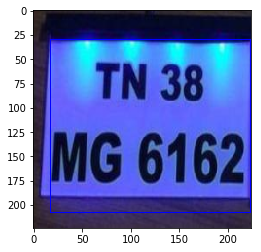

Cropped image ->


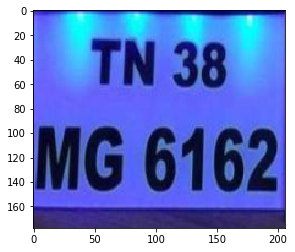

TN 38
MG 6162
Original image with rectangle boundary->


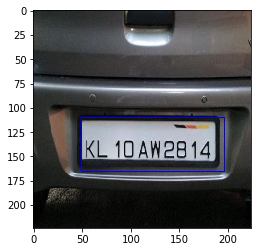

Cropped image ->


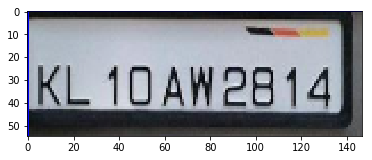

KL IOAN 2814


0

In [32]:
# Testing

get_number(65)
get_number(144)

In [ ]:
# miss_count = 0
# for i in range (0,len(license_plate_df)):
#     print("Figure {}".format(i))
#     miss_count += get_number(i)
#     print("------------------")
# print("Total images miss {}".format(miss_count))